# Long Short Trading Strategy backtest
The following notebook implements the backtest of the trading strategy based on the idea that the instruments that strongly outperforms the market tend to go down in the nearest future and vice versa. More detailed description of the strategy can be found in docstring for LongShortTradingStrategy.py


Following steps are performed in the research:
   1. Prepare the data
   2. Validate strategy configuration and parameters 
   3. Run the optimal strategy on test data

In [1]:
from LongShortTradingStrategy import LongShortTradingStrategy
from tools import *
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

### 1. Load and prepare the data
We use 1h time bars for the Binance spot market during the period of 2020-01-01 - 2022-01-01

In [2]:
bars_data = load_ohlc_data('binance_1h')
bars_data.head()

1INCHUSDT                       AAVEUSDT                 \
                         open high low close volume     open high low close   
timestamp                                                                     
2020-01-01 00:00:00       NaN  NaN NaN   NaN    NaN      NaN  NaN NaN   NaN   
2020-01-01 01:00:00       NaN  NaN NaN   NaN    NaN      NaN  NaN NaN   NaN   
2020-01-01 02:00:00       NaN  NaN NaN   NaN    NaN      NaN  NaN NaN   NaN   
2020-01-01 03:00:00       NaN  NaN NaN   NaN    NaN      NaN  NaN NaN   NaN   
2020-01-01 04:00:00       NaN  NaN NaN   NaN    NaN      NaN  NaN NaN   NaN   

                            ... ZILUSDT                       ZRXUSDT          \
                    volume  ...    open high low close volume    open    high   
timestamp                   ...                                                 
2020-01-01 00:00:00    NaN  ...     NaN  NaN NaN   NaN    NaN  0.1809  0.1821   
2020-01-01 01:00:00    NaN  ...     NaN  NaN NaN   NaN    NaN  0.1815  0.1816   
2020-01-01 02:00:00    NaN  ...     NaN  NaN NaN   NaN    NaN  0.1811  0.1817   
2020-01-01 03:00:00    NaN  ...     NaN  NaN NaN   NaN    NaN  0.1809  0.1815   
2020-01-01 04:00:00    NaN  ...     NaN  NaN NaN   NaN    NaN  0.1807  0.1808   

                                                  
                        low   close       volume  
timestamp                                         
2020-01-01 00:00:00  0.1809  0.1809  1648.064131  
2020-01-01 01:00:00  0.1809  0.1812  3898.514769  
2020-01-01 02:00:00  0.1809  0.1809  9104.012800  
2020-01-01 03:00:00  0.1809  0.1811  3405.025931  
2020-01-01 04:00:00  0.1800  0.1800  8824.003451  

[5 rows x 1560 columns]

##### The strategy requires only close prices

In [3]:
prices_data = get_bar_value_for_all_tickers(bars_data, 'close')
prices_data.head()

,1INCHUSDT,AAVEUSDT,ACMUSDT,ADAUSDT,ADXUSDT,AGLDUSDT,AIONUSDT,AKROUSDT,ALCXUSDT,ALGOUSDT,...,XTZUSDT,XVGUSDT,XVSUSDT,YFIIUSDT,YFIUSDT,YGGUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,NaN,NaN,NaN,0.03278,NaN,NaN,NaN,NaN,NaN,0.2167,...,NaN,NaN,NaN,NaN,NaN,NaN,27.43,NaN,NaN,0.1809
2020-01-01 01:00:00,NaN,NaN,NaN,0.03299,NaN,NaN,NaN,NaN,NaN,0.2175,...,1.3487,NaN,NaN,NaN,NaN,NaN,27.67,NaN,NaN,0.1812
2020-01-01 02:00:00,NaN,NaN,NaN,0.03317,NaN,NaN,NaN,NaN,NaN,0.2179,...,1.3570,NaN,NaN,NaN,NaN,NaN,27.71,NaN,NaN,0.1809
2020-01-01 03:00:00,NaN,NaN,NaN,0.03303,NaN,NaN,NaN,NaN,NaN,0.2194,...,1.3424,NaN,NaN,NaN,NaN,NaN,27.66,NaN,NaN,0.1811
2020-01-01 04:00:00,NaN,NaN,NaN,0.03299,NaN,NaN,NaN,NaN,NaN,0.2190,...,1.3306,NaN,NaN,NaN,NaN,NaN,27.63,NaN,NaN,0.1800


#### Split into data on training, testing, and validation samples
We will use the training data to optimize hyperparameters of the current configuration of the strategy. Each configuration is tested on the validation dataset. During research we can change the configuration of the strategy - add new rules or indicators. After choosing the best configuration, we will test it on the testing dataset - these will be our final results.

In [4]:
all_train_prices_data, test_prices_data = train_test_split(prices_data, test_size=0.25, train_size=0.75, shuffle=False)
train_prices_data, validation_prices_data = train_test_split(all_train_prices_data, test_size=1/3, train_size=2/3,
                                                             shuffle=False)
train_prices_data.head()

,1INCHUSDT,AAVEUSDT,ACMUSDT,ADAUSDT,ADXUSDT,AGLDUSDT,AIONUSDT,AKROUSDT,ALCXUSDT,ALGOUSDT,...,XTZUSDT,XVGUSDT,XVSUSDT,YFIIUSDT,YFIUSDT,YGGUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,NaN,NaN,NaN,0.03278,NaN,NaN,NaN,NaN,NaN,0.2167,...,NaN,NaN,NaN,NaN,NaN,NaN,27.43,NaN,NaN,0.1809
2020-01-01 01:00:00,NaN,NaN,NaN,0.03299,NaN,NaN,NaN,NaN,NaN,0.2175,...,1.3487,NaN,NaN,NaN,NaN,NaN,27.67,NaN,NaN,0.1812
2020-01-01 02:00:00,NaN,NaN,NaN,0.03317,NaN,NaN,NaN,NaN,NaN,0.2179,...,1.3570,NaN,NaN,NaN,NaN,NaN,27.71,NaN,NaN,0.1809
2020-01-01 03:00:00,NaN,NaN,NaN,0.03303,NaN,NaN,NaN,NaN,NaN,0.2194,...,1.3424,NaN,NaN,NaN,NaN,NaN,27.66,NaN,NaN,0.1811
2020-01-01 04:00:00,NaN,NaN,NaN,0.03299,NaN,NaN,NaN,NaN,NaN,0.2190,...,1.3306,NaN,NaN,NaN,NaN,NaN,27.63,NaN,NaN,0.1800


### 2. Validate strategy
We will use the optuna library (https://optuna.org) for the optimization of strategy parameters. The optimized function is Sharpe ratio.

The first configuration uses very simple set of rules: buy/sell given quantiles of the most unprofitable/profitable instruments from the universe. Close position when the number of periods in position exceeds the given limit, or when the position return is beyound the given bounds. Therefore, optimized parameters are quantiles, time period limit and position return bounds.

We allow the optimizer to set the upper quantile to 0.0. It means that we consider the configuration of the strategy which opens only long positions.

In [13]:
train_strategy1, best_params1 = optimize_strategy_params(train_prices_data,
                                                         up_q_bounds=(0.0, 0.1), down_q_bounds=(0.01, 0.1),
                                                         max_profit_bounds=(0.001, 0.1), max_loss_bounds=(0.001, 0.1),
                                                         max_t_in_pos_bounds=(5, 50),
                                                         n_trials=20)

[I 2022-05-09 10:32:06,292] A new study created in memory with name: no-name-39735797-1e2c-4066-a420-798d3469fb96
[I 2022-05-09 10:32:36,105] Trial 0 finished with value: 6.943520030709316 and parameters: {'up_q': 0.03745401188473625, 'down_q': 0.09556428757689246, 'max_profit': 0.07346740023932911, 'max_loss': 0.06026718993550663, 'max_t_in_pos': 12}. Best is trial 0 with value: 6.943520030709316.
[I 2022-05-09 10:32:38,509] Trial 1 finished with value: -100.0 and parameters: {'up_q': 0.015599452033620266, 'down_q': 0.015227525095137952, 'max_profit': 0.08675143843171859, 'max_loss': 0.06051038616257767, 'max_t_in_pos': 37}. Best is trial 0 with value: 6.943520030709316.
[I 2022-05-09 10:33:10,594] Trial 2 finished with value: 6.239537132682789 and parameters: {'up_q': 0.0020584494295802446, 'down_q': 0.0972918866945795, 'max_profit': 0.08341182143924175, 'max_loss': 0.022021571957149343, 'max_t_in_pos': 13}. Best is trial 0 with value: 6.943520030709316.
[I 2022-05-09 10:33:38,431] T

The strategy looks incredibly good on the training dataset: the btc graph even looks flat in comparison with the strategy! However, correlation with btc is quite high.
Let's see how it works on the validation dataset.

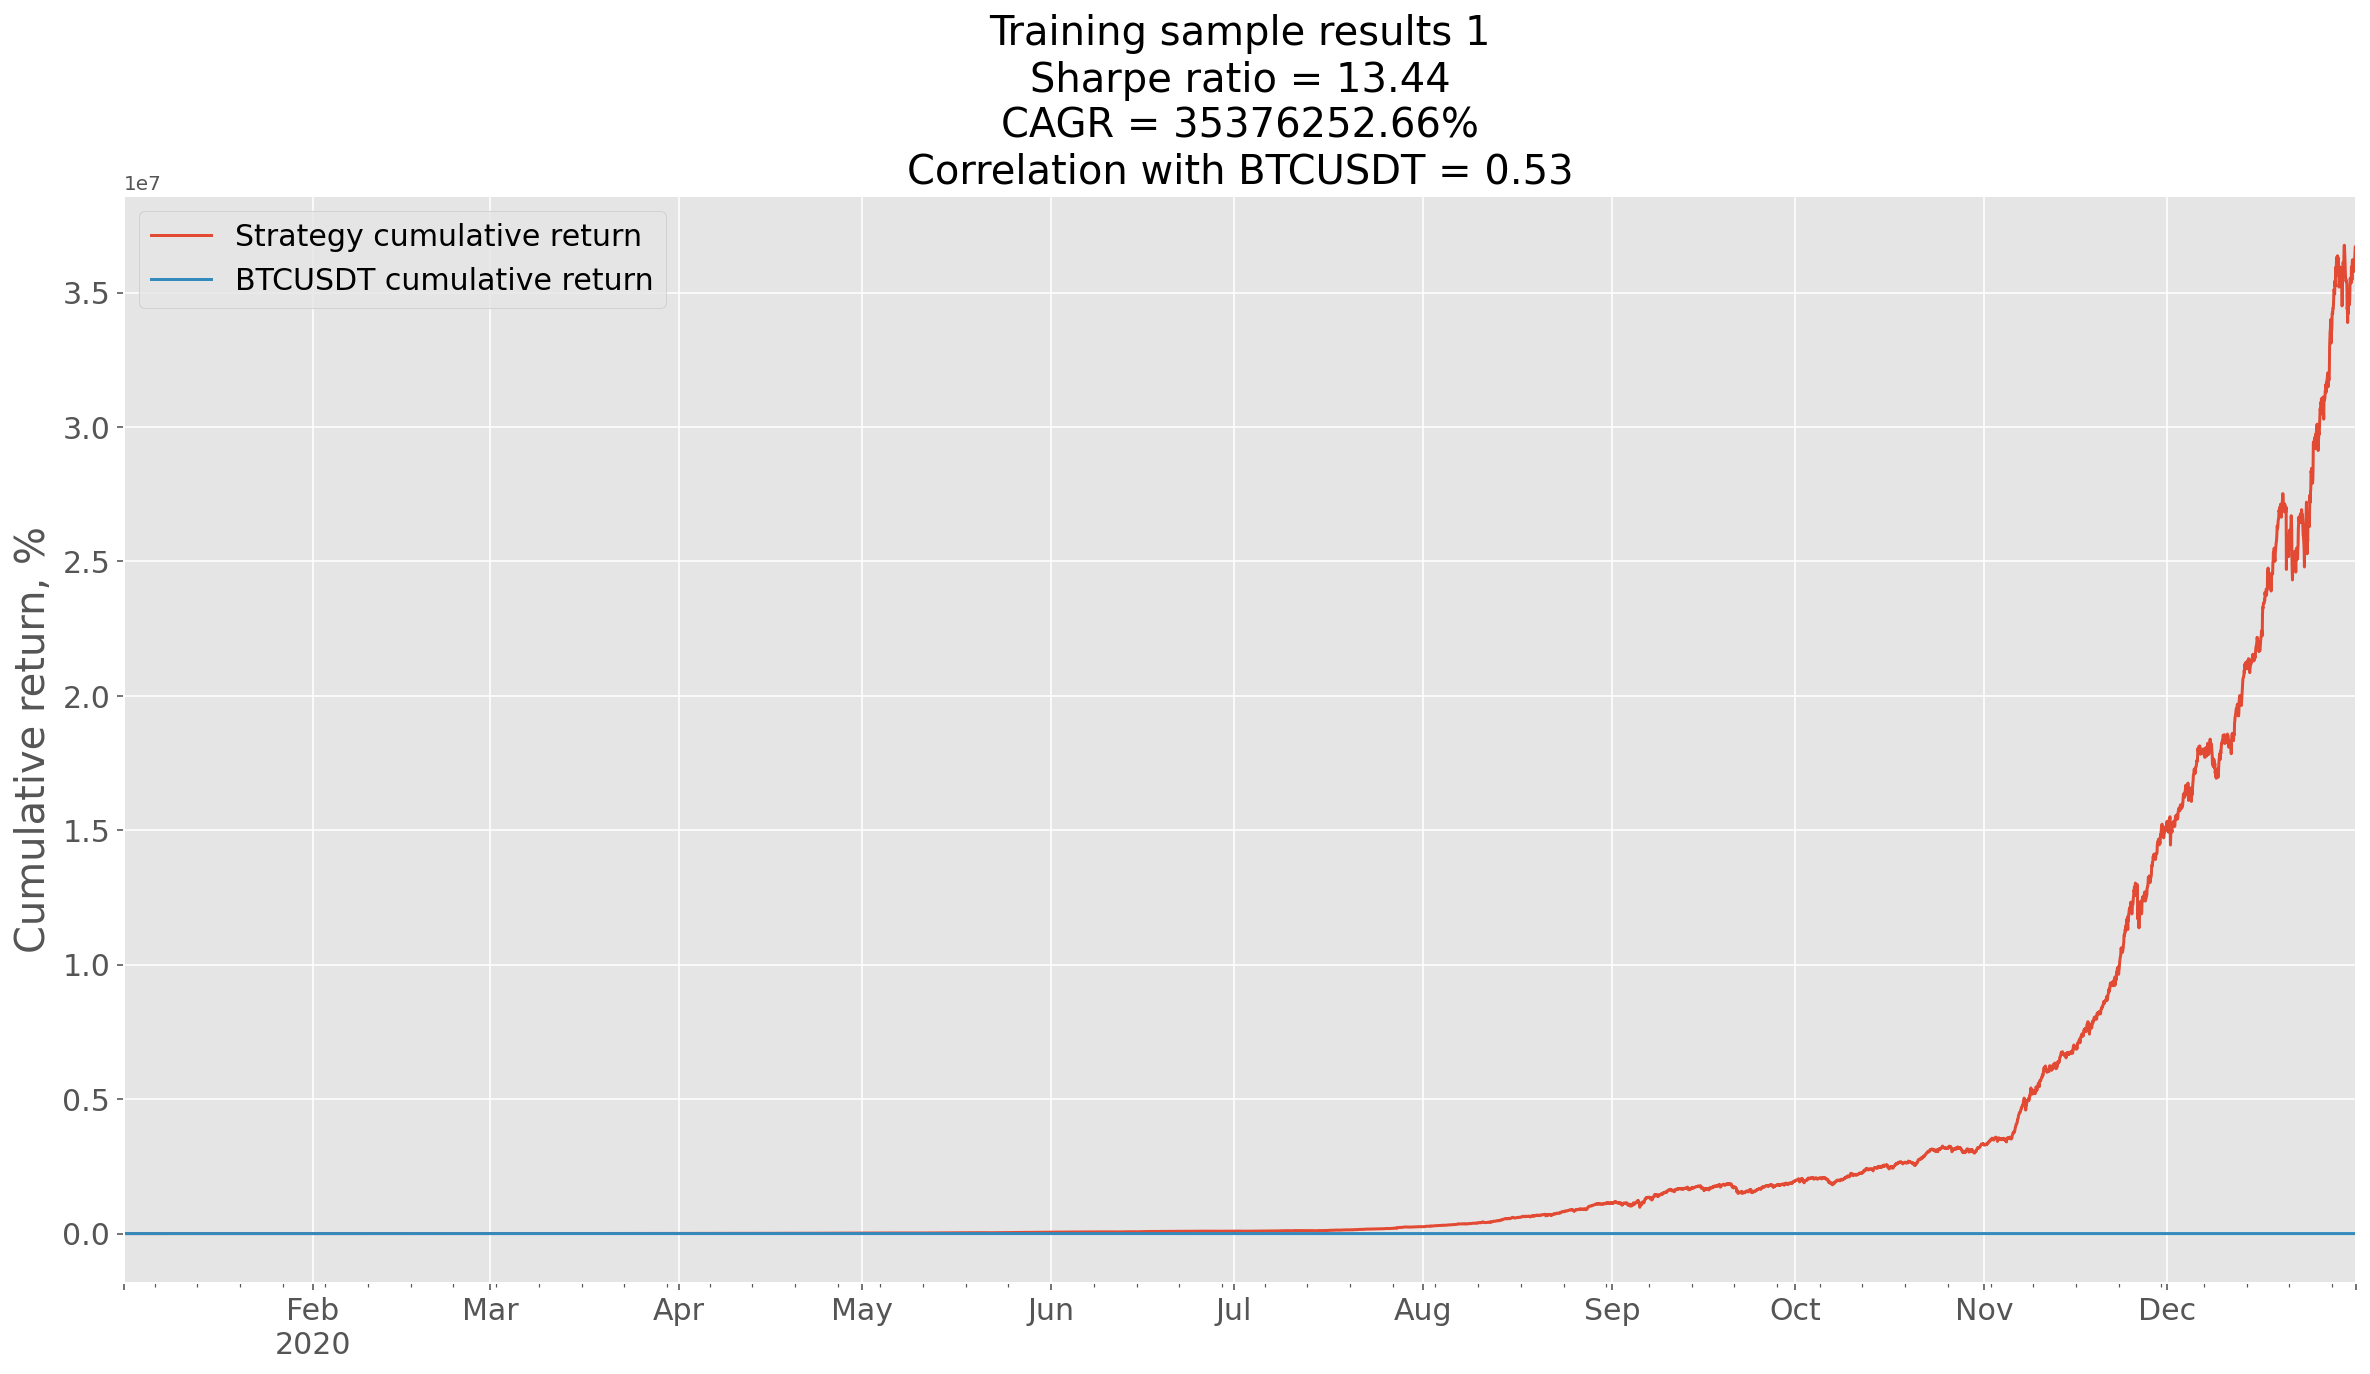

In [14]:
plot_strategy_results(train_strategy1, 'Training sample results 1')

Still looks good, but correlation is even higher. Let's try one more configuration.

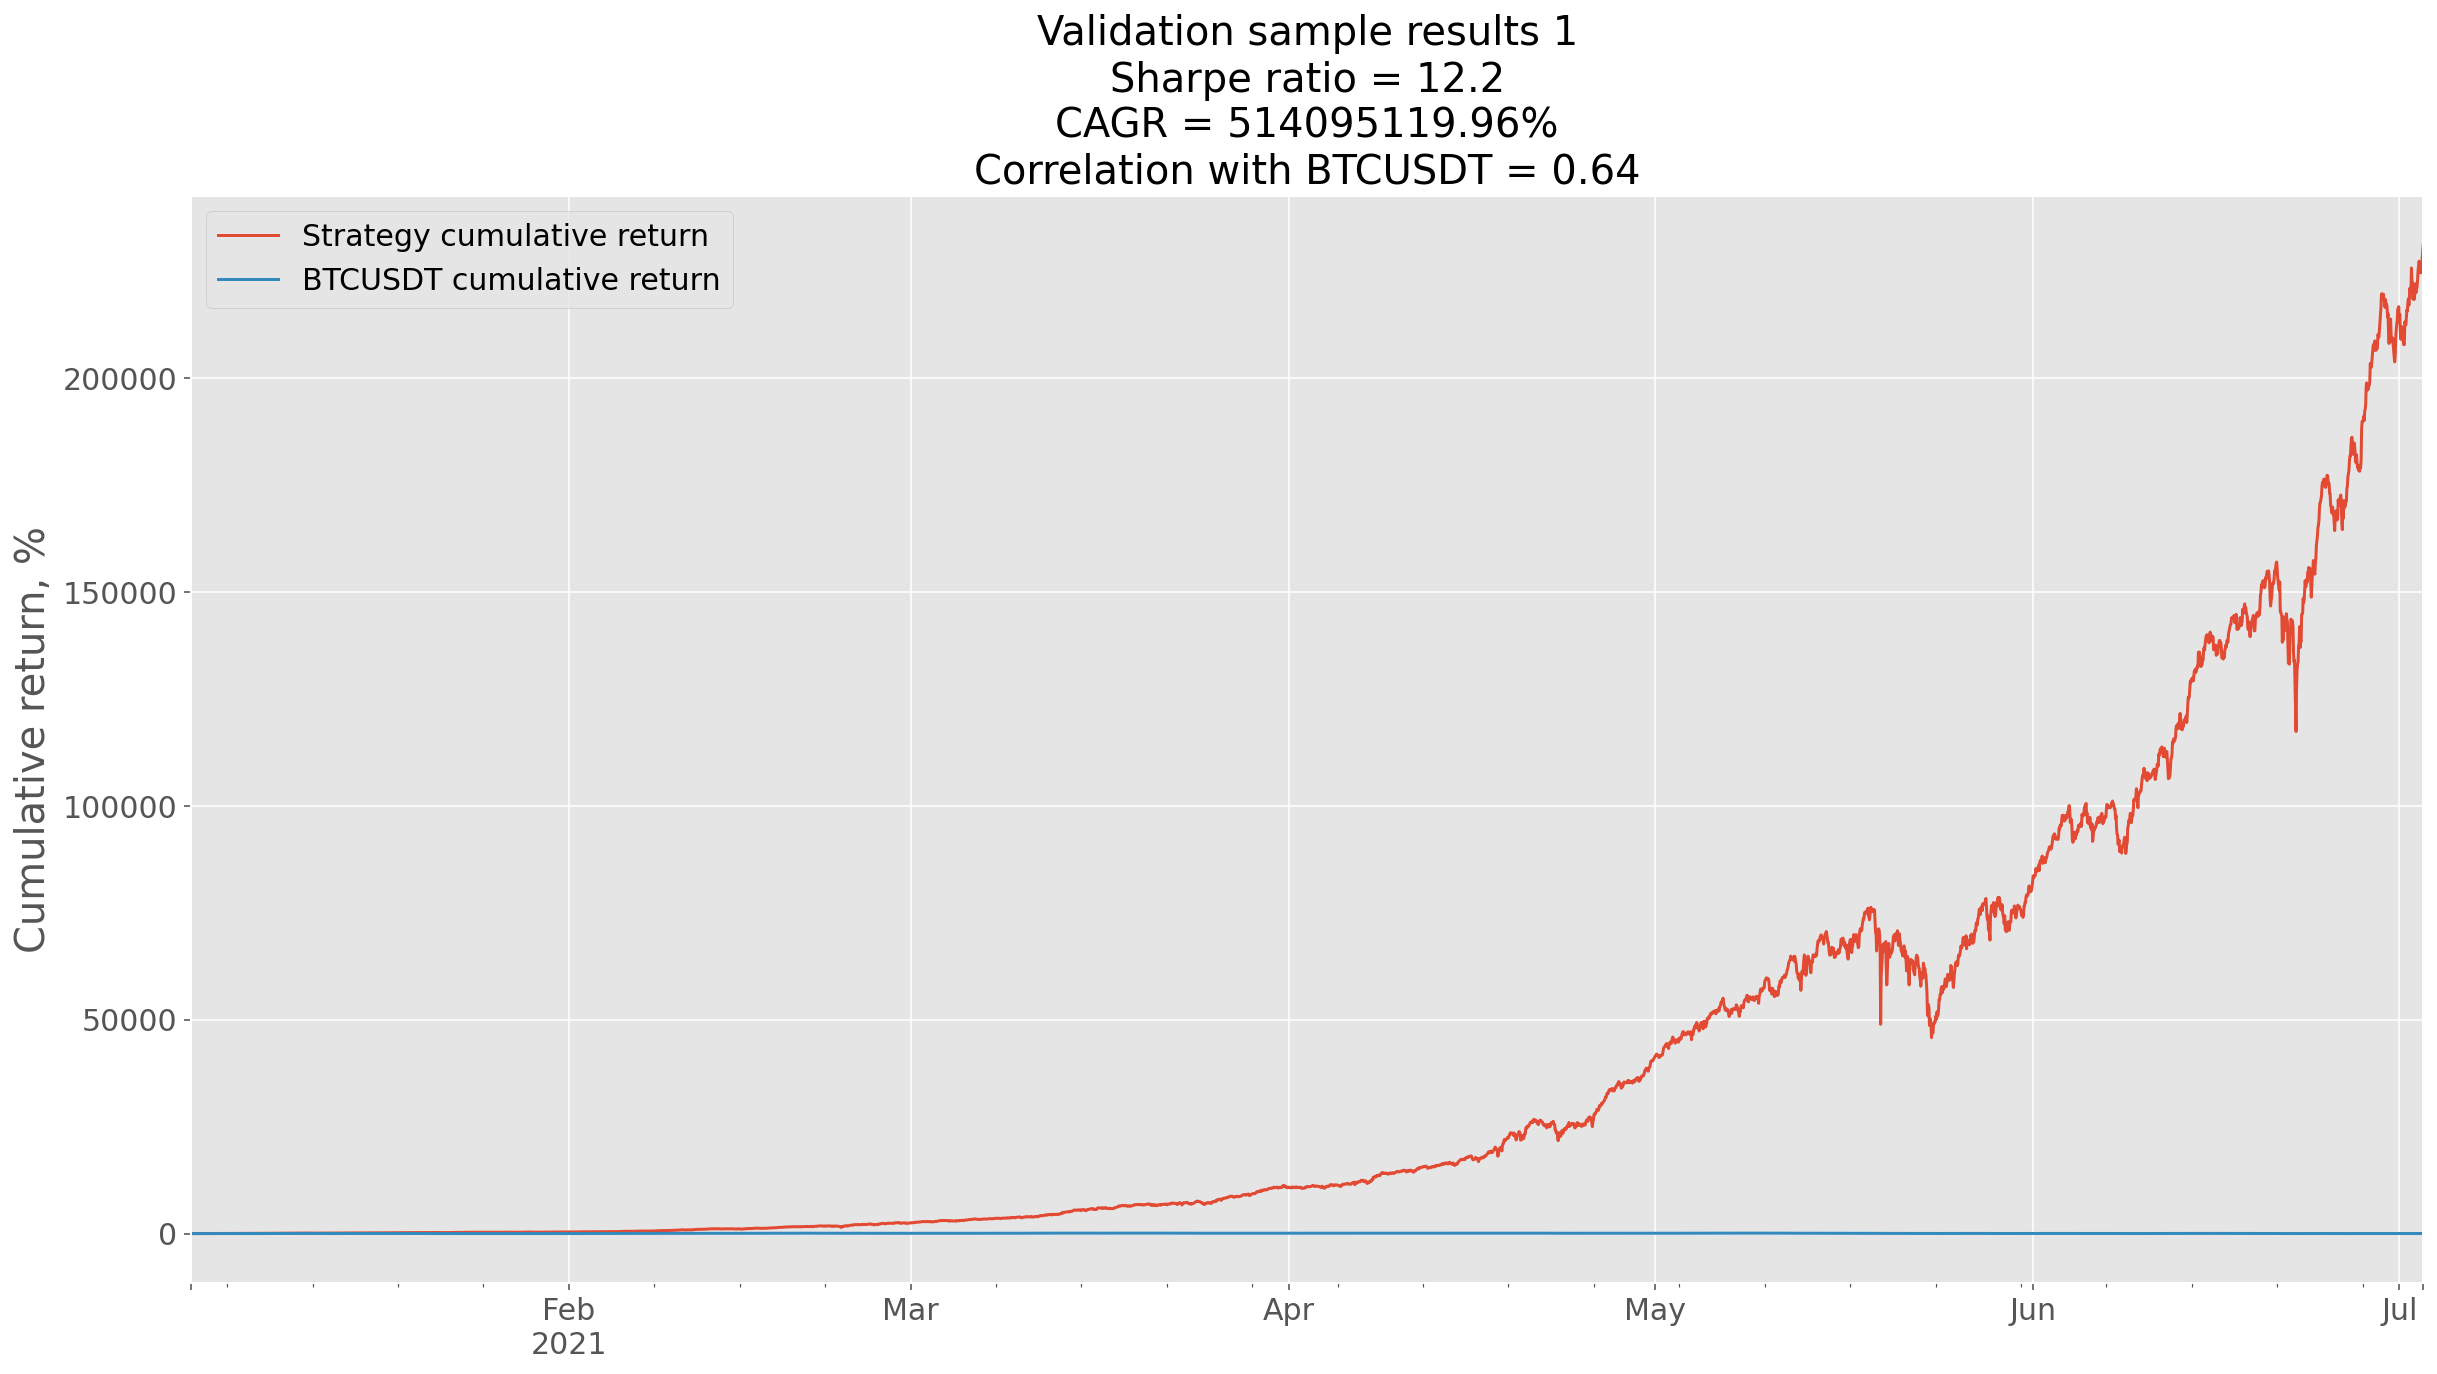

In [15]:
validation_strategy1 = LongShortTradingStrategy(validation_prices_data, benchmark_ticker='BTCUSDT')
validation_strategy1.set_strategy_params(**best_params1)
validation_strategy1.run()
plot_strategy_results(validation_strategy1, 'Validation sample results 1')

It makes sense to react to possible pumps&dumps which can spoil the results of the strategy. If pupmp happens for an instrument, the strategy will detect the huge return and short this instrument. Hovewer, price continues to grow untill the pump is ended. Let's introduce limits for maximum consequtive time periods is profit/loss. For example, if an instrument is sold at the beginning of the pump, the limit will not let it live for a very long time. Or if we luckily bought it right before the pump, the another limit must be triggired the dump happens.

In [16]:
train_strategy2, best_params2 = optimize_strategy_params(train_prices_data,
                                                         up_q_bounds=(0.0, 0.1), down_q_bounds=(0.01, 0.1),
                                                         max_profit_bounds=(0.001, 0.1), max_loss_bounds=(0.001, 0.1),
                                                         max_t_in_pos_bounds=(5, 50),
                                                         optimize_max_t_in_profit_and_loss=True,
                                                         n_trials=20)

[I 2022-05-09 10:39:28,760] A new study created in memory with name: no-name-18c3ec40-055d-47dc-bd43-c760a2c9f5dd
[I 2022-05-09 10:39:58,169] Trial 0 finished with value: 20.26977914914926 and parameters: {'up_q': 0.03745401188473625, 'down_q': 0.09556428757689246, 'max_profit': 0.07346740023932911, 'max_loss': 0.06026718993550663, 'max_t_in_pos': 12, 'max_t_in_profit': 2, 'max_t_in_loss': 1}. Best is trial 0 with value: 20.26977914914926.
[I 2022-05-09 10:40:05,884] Trial 1 finished with value: -100.0 and parameters: {'up_q': 0.08661761457749352, 'down_q': 0.0641003510568888, 'max_profit': 0.07109918520180851, 'max_loss': 0.0030378649352844423, 'max_t_in_pos': 49, 'max_t_in_profit': 41, 'max_t_in_loss': 11}. Best is trial 0 with value: 20.26977914914926.
[I 2022-05-09 10:40:34,919] Trial 2 finished with value: 11.360531689087065 and parameters: {'up_q': 0.018182496720710064, 'down_q': 0.026506405886809047, 'max_profit': 0.03111998205299424, 'max_loss': 0.05295088673159155, 'max_t_in_p

Surprisingly it turns out that optimal value of profit/loss time periods limits is 1 for both limits. It means that we just close the position in the next period right after it was opened.
Let's see how this configuration with optimized quantiles works on the validation dataset.

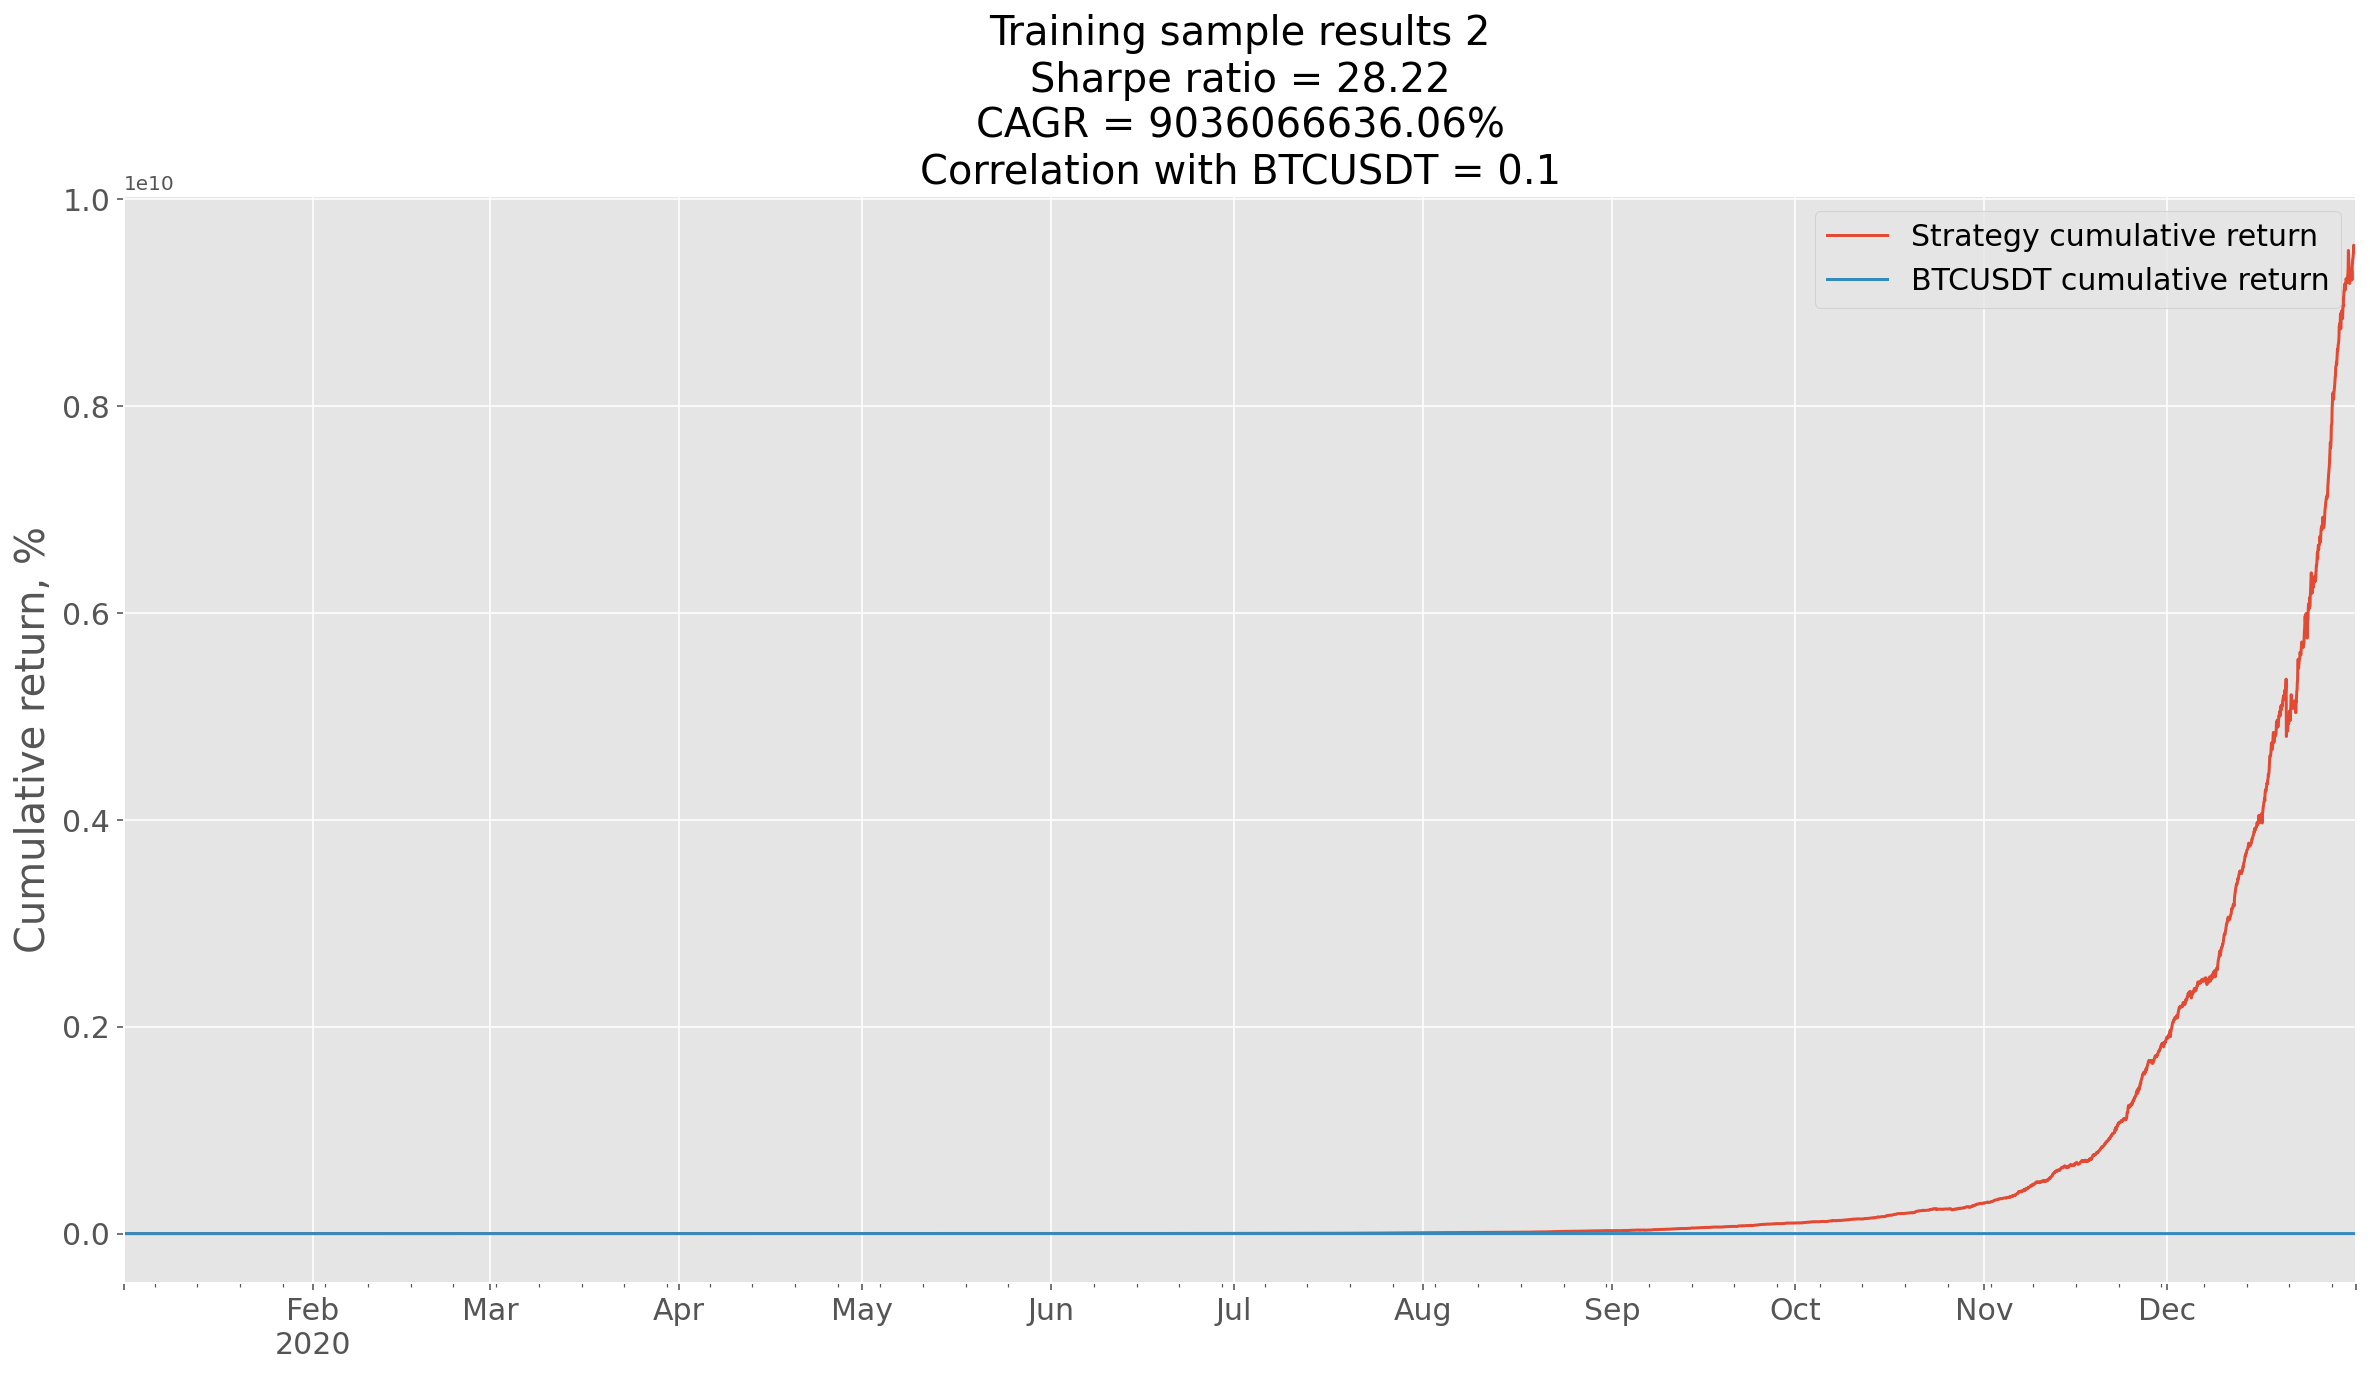

In [17]:
train_strategy2.set_strategy_params(up_q=0.06348527073042395, down_q=0.07318152559512171, max_t_in_pos=1)
train_strategy2.run()
plot_strategy_results(train_strategy2, 'Training sample results 2')

Looks very good! And now correlation is low. Let's select this configuration and see what are the results on the testing dataset.

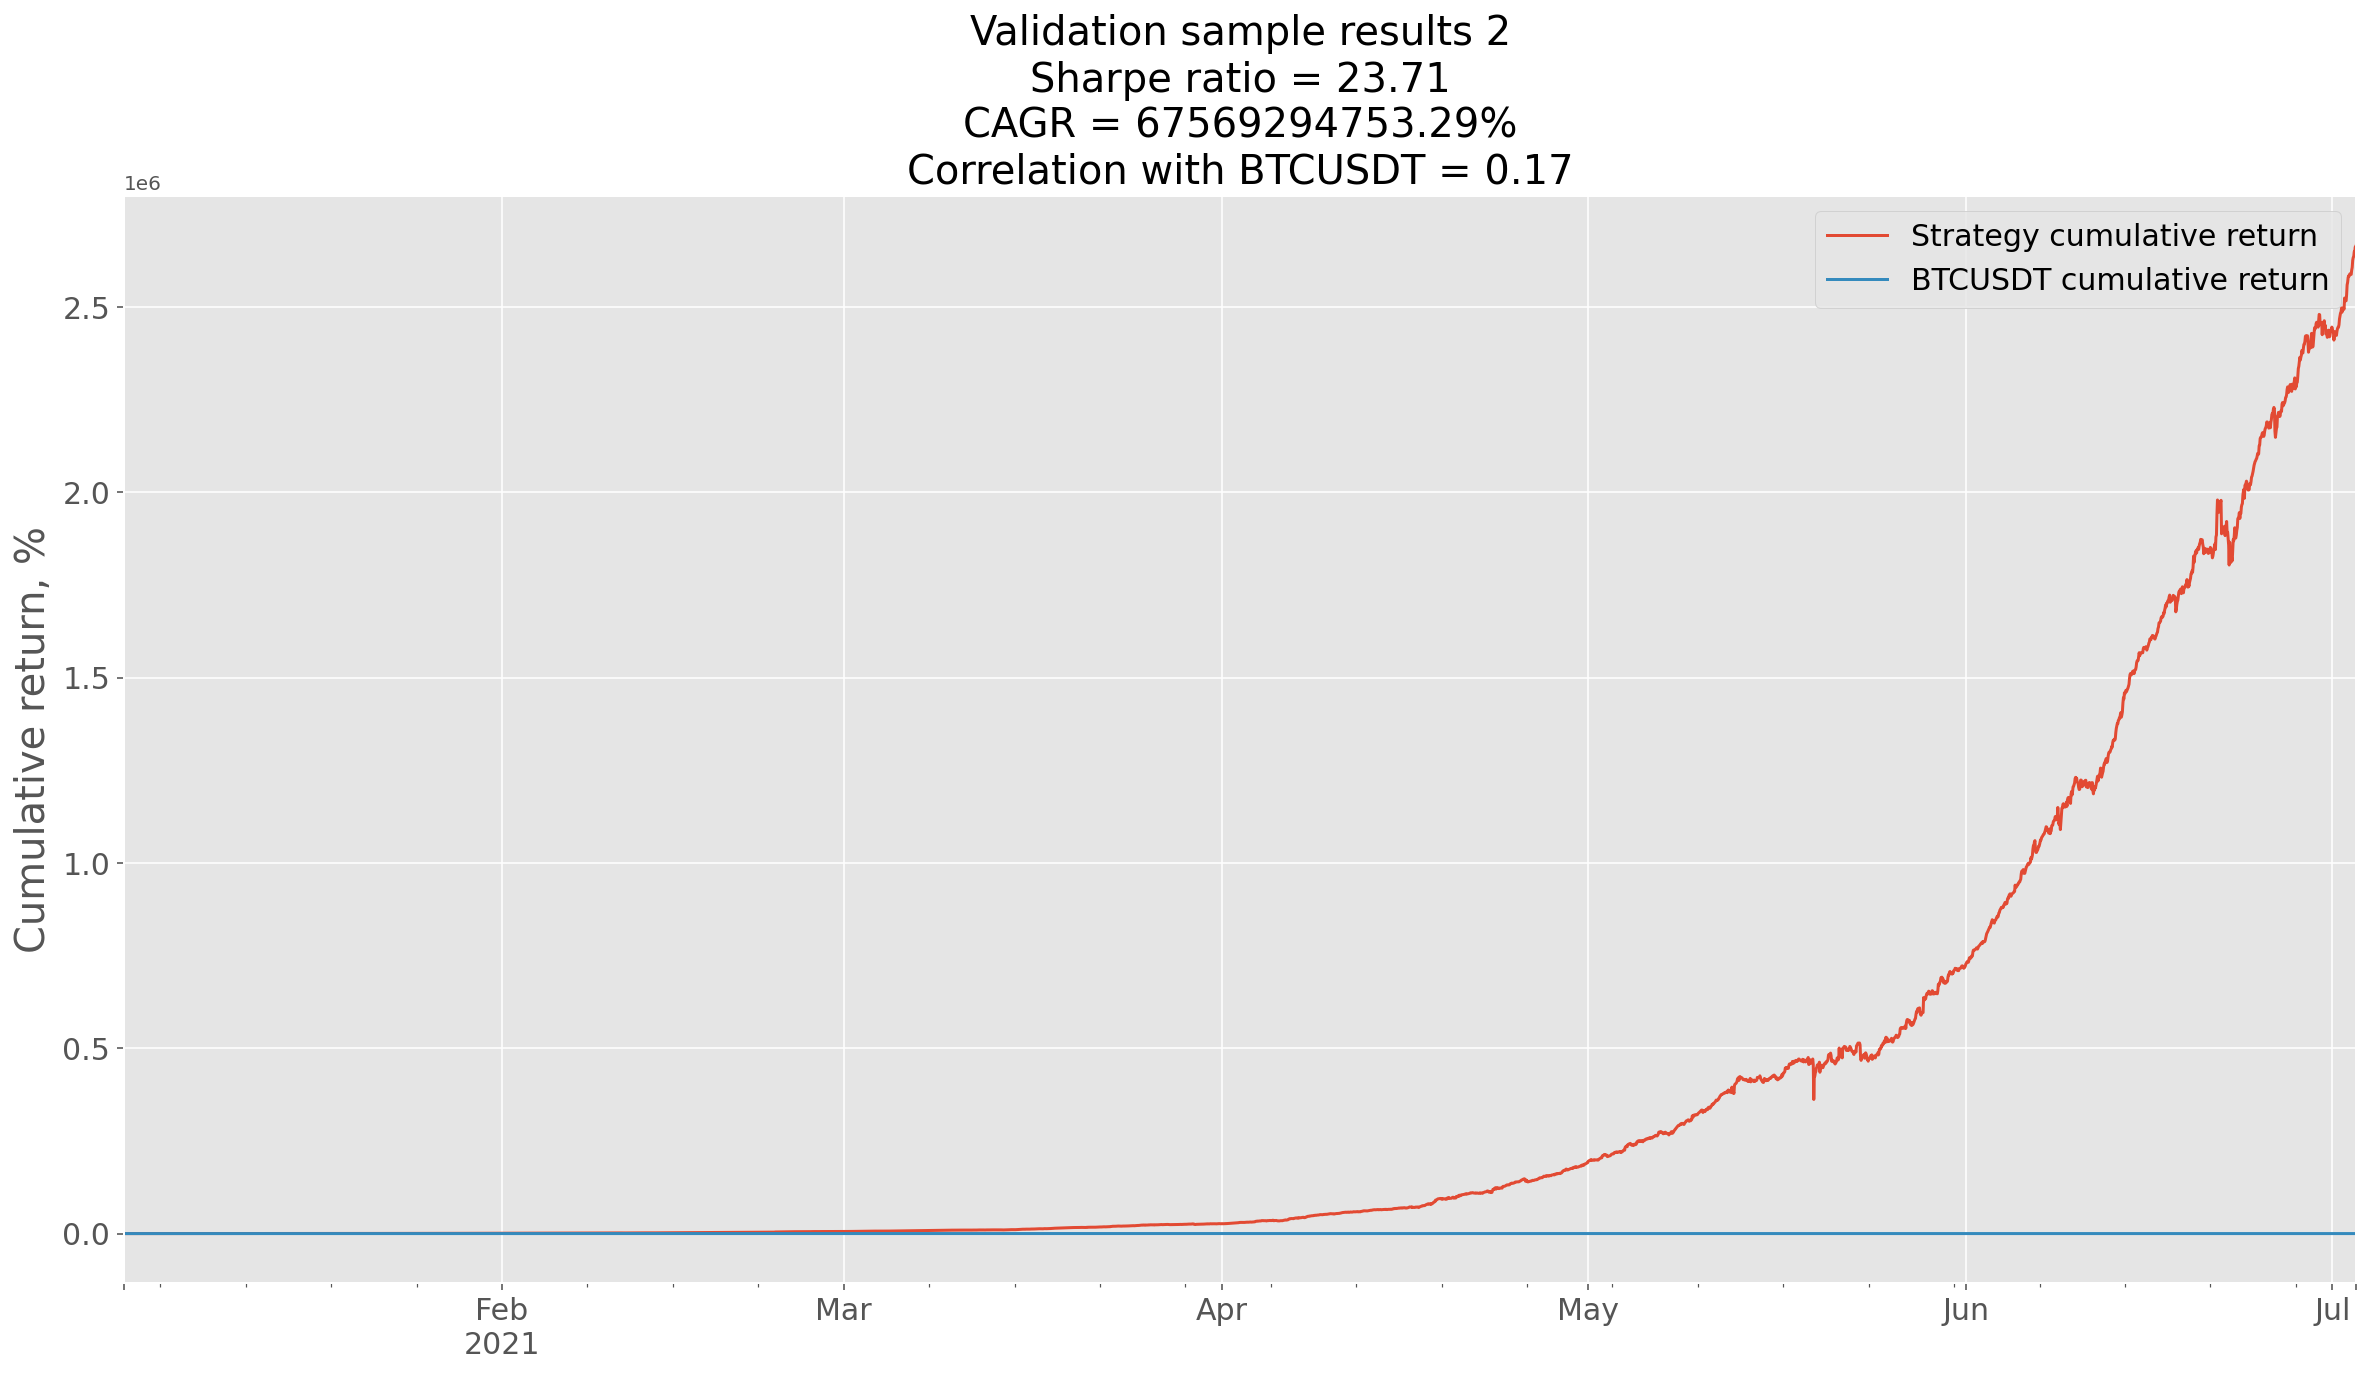

In [18]:
validation_strategy2 = LongShortTradingStrategy(validation_prices_data, benchmark_ticker='BTCUSDT')
validation_strategy2.set_strategy_params(up_q=0.06348527073042395, down_q=0.07318152559512171, max_t_in_pos=1)
validation_strategy2.run()
plot_strategy_results(validation_strategy2, 'Validation sample results 2')

### 3. Run the strategy on test data
It seems that the most important rule in the strategy is to close positions one time interval after they are opened, regardless of the financial result of the position. Quantiles are approximately equal in the set of optimal parameters. Let's set each to 0.07 and run it on the testing data

Strategy keeps good results on the testing dataset. Therefore, we can subject the strategy to more thorough testing: add comission, spreads, volumes, order book to the simulation process.

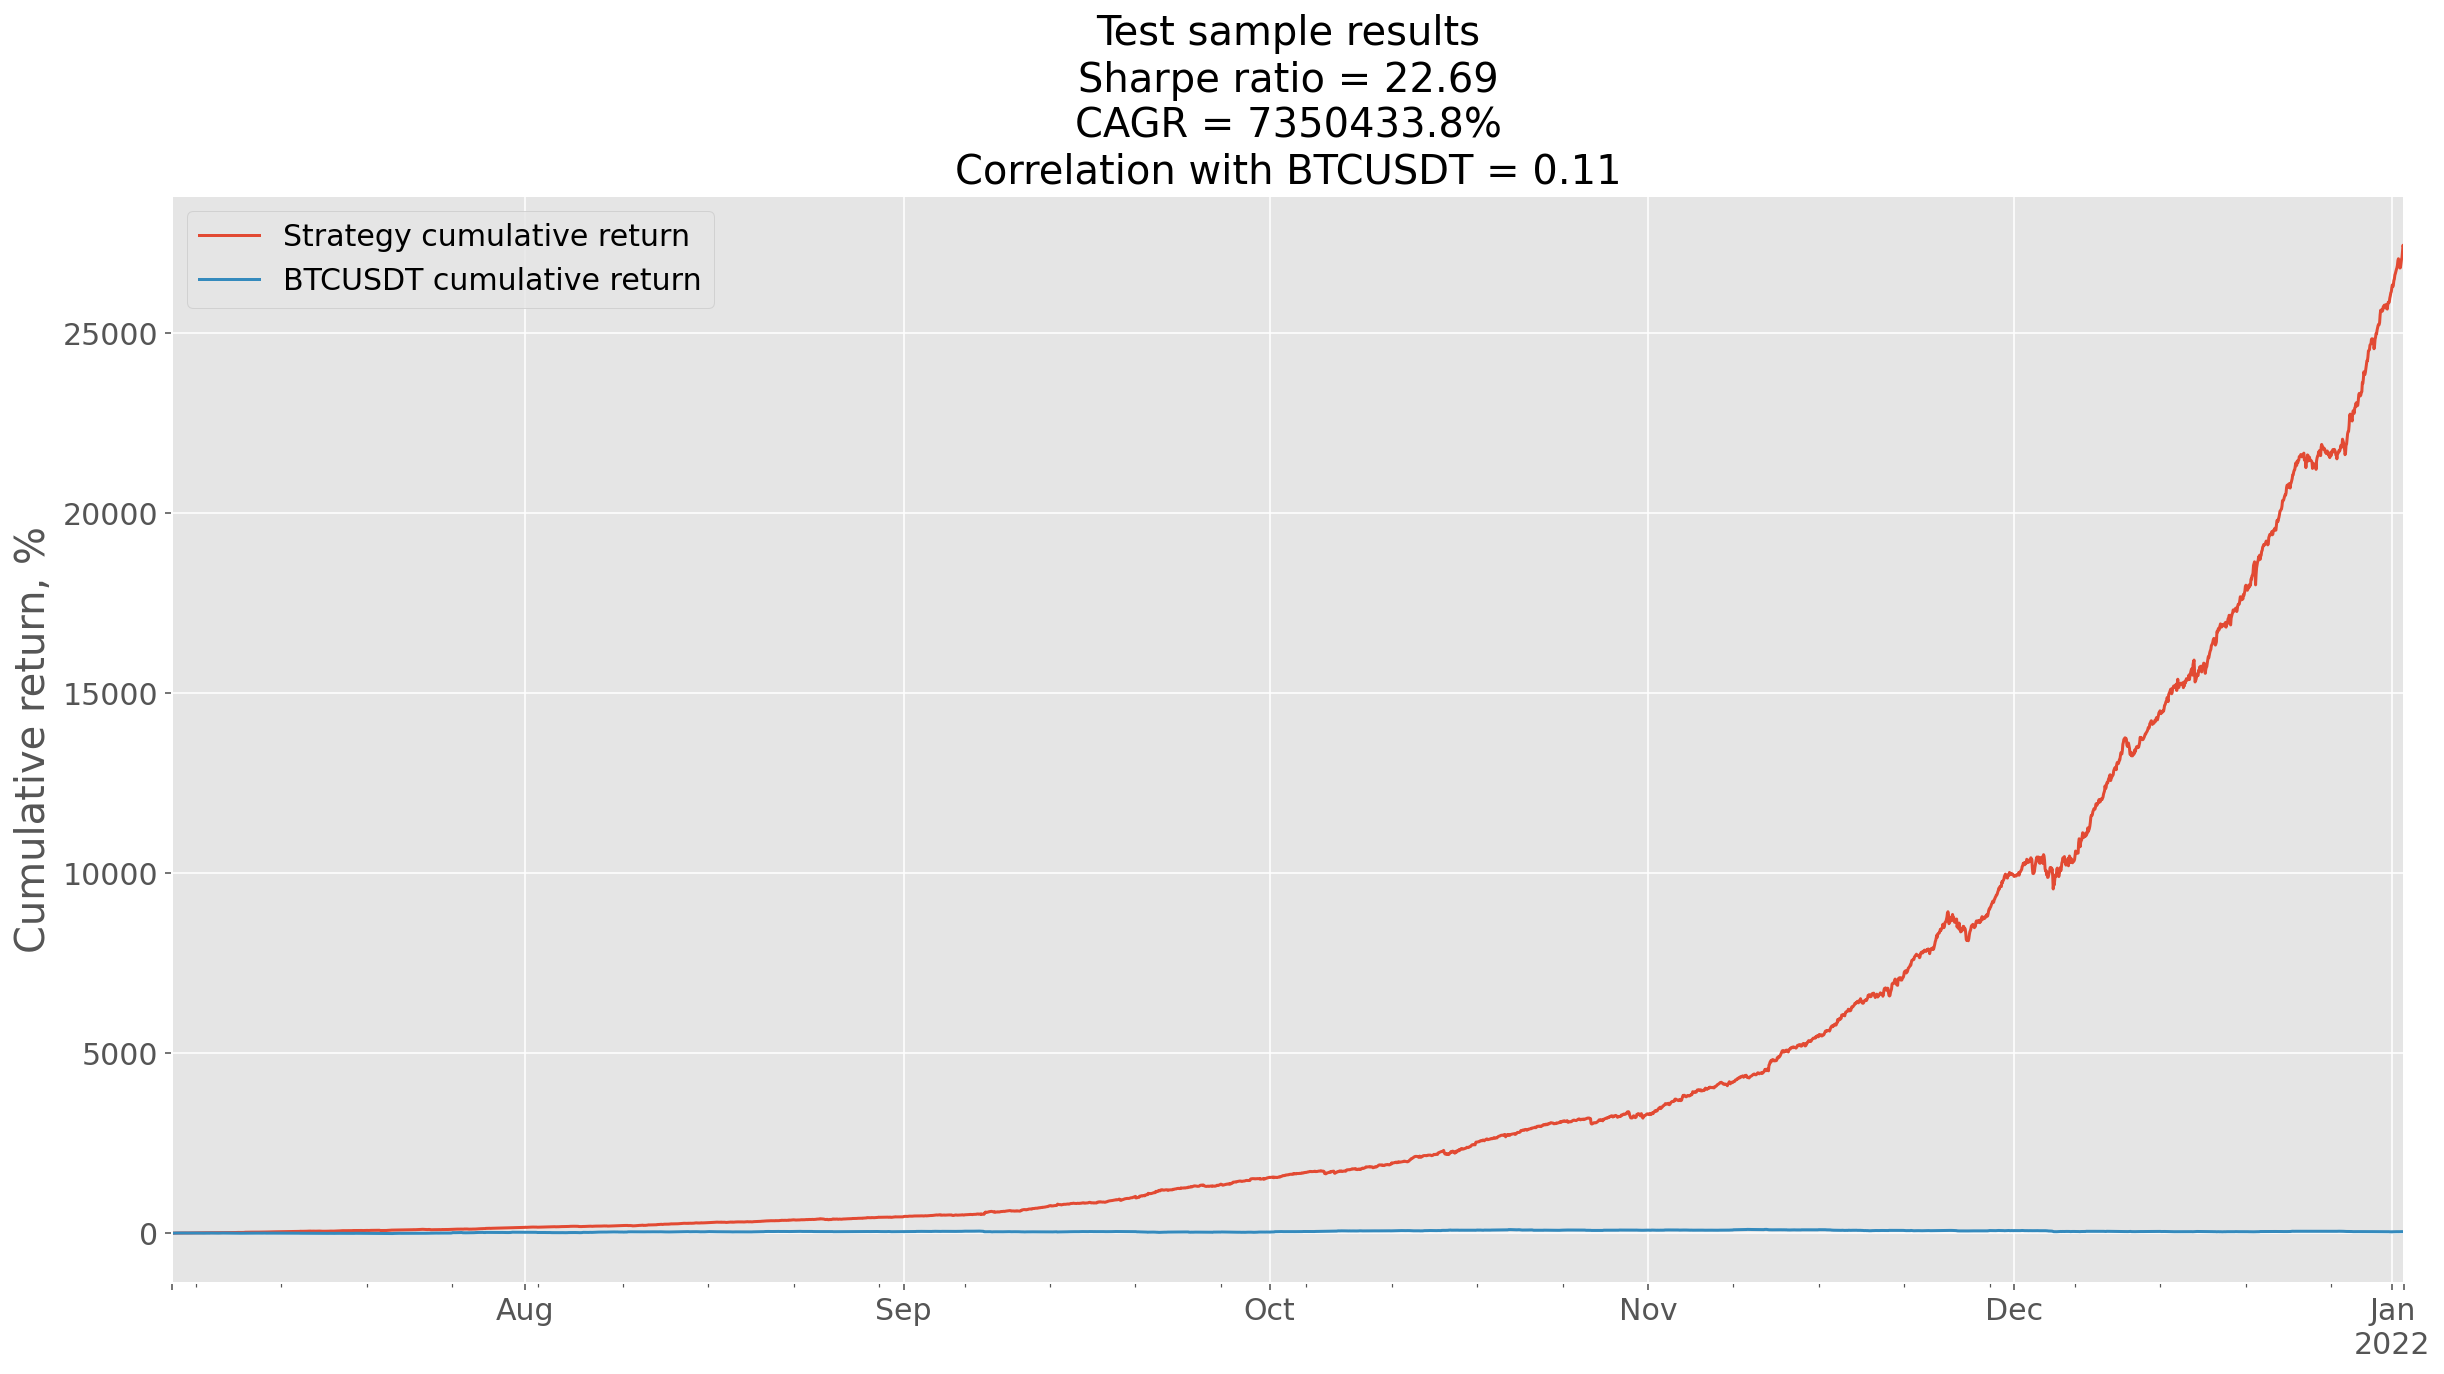

In [20]:
test_strategy = LongShortTradingStrategy(test_prices_data, benchmark_ticker='BTCUSDT')
test_strategy.set_strategy_params(up_q=0.07, down_q=0.07, max_t_in_pos=1)
test_strategy.run()
plot_strategy_results(test_strategy, 'Test sample results')

### * Verify that results are reliable
Looking at the enormous growth of the strategy capital on the whole dataset (CAGR = 2219163978.13% means ~4.74% per trading day!), it seems that there is a mistake in the code that simulates the trading process on the historical data.

Let's do a reverse engineering to make sure that results are not trash: log each trade of the strategy (timestamp, ticker, quantity, price) and rebuild the strategy's capital dynamics from the logs. If it is the same, we can state that the results are reliable.

Also let's see what proportion of the trade volume in cash money before trade is at the opening of the position. According to the strategy rules, absolute sum of long and short positions shall not exceed available cash money.

Finally, let's verify that prices in the logs math the prices in the dataset.

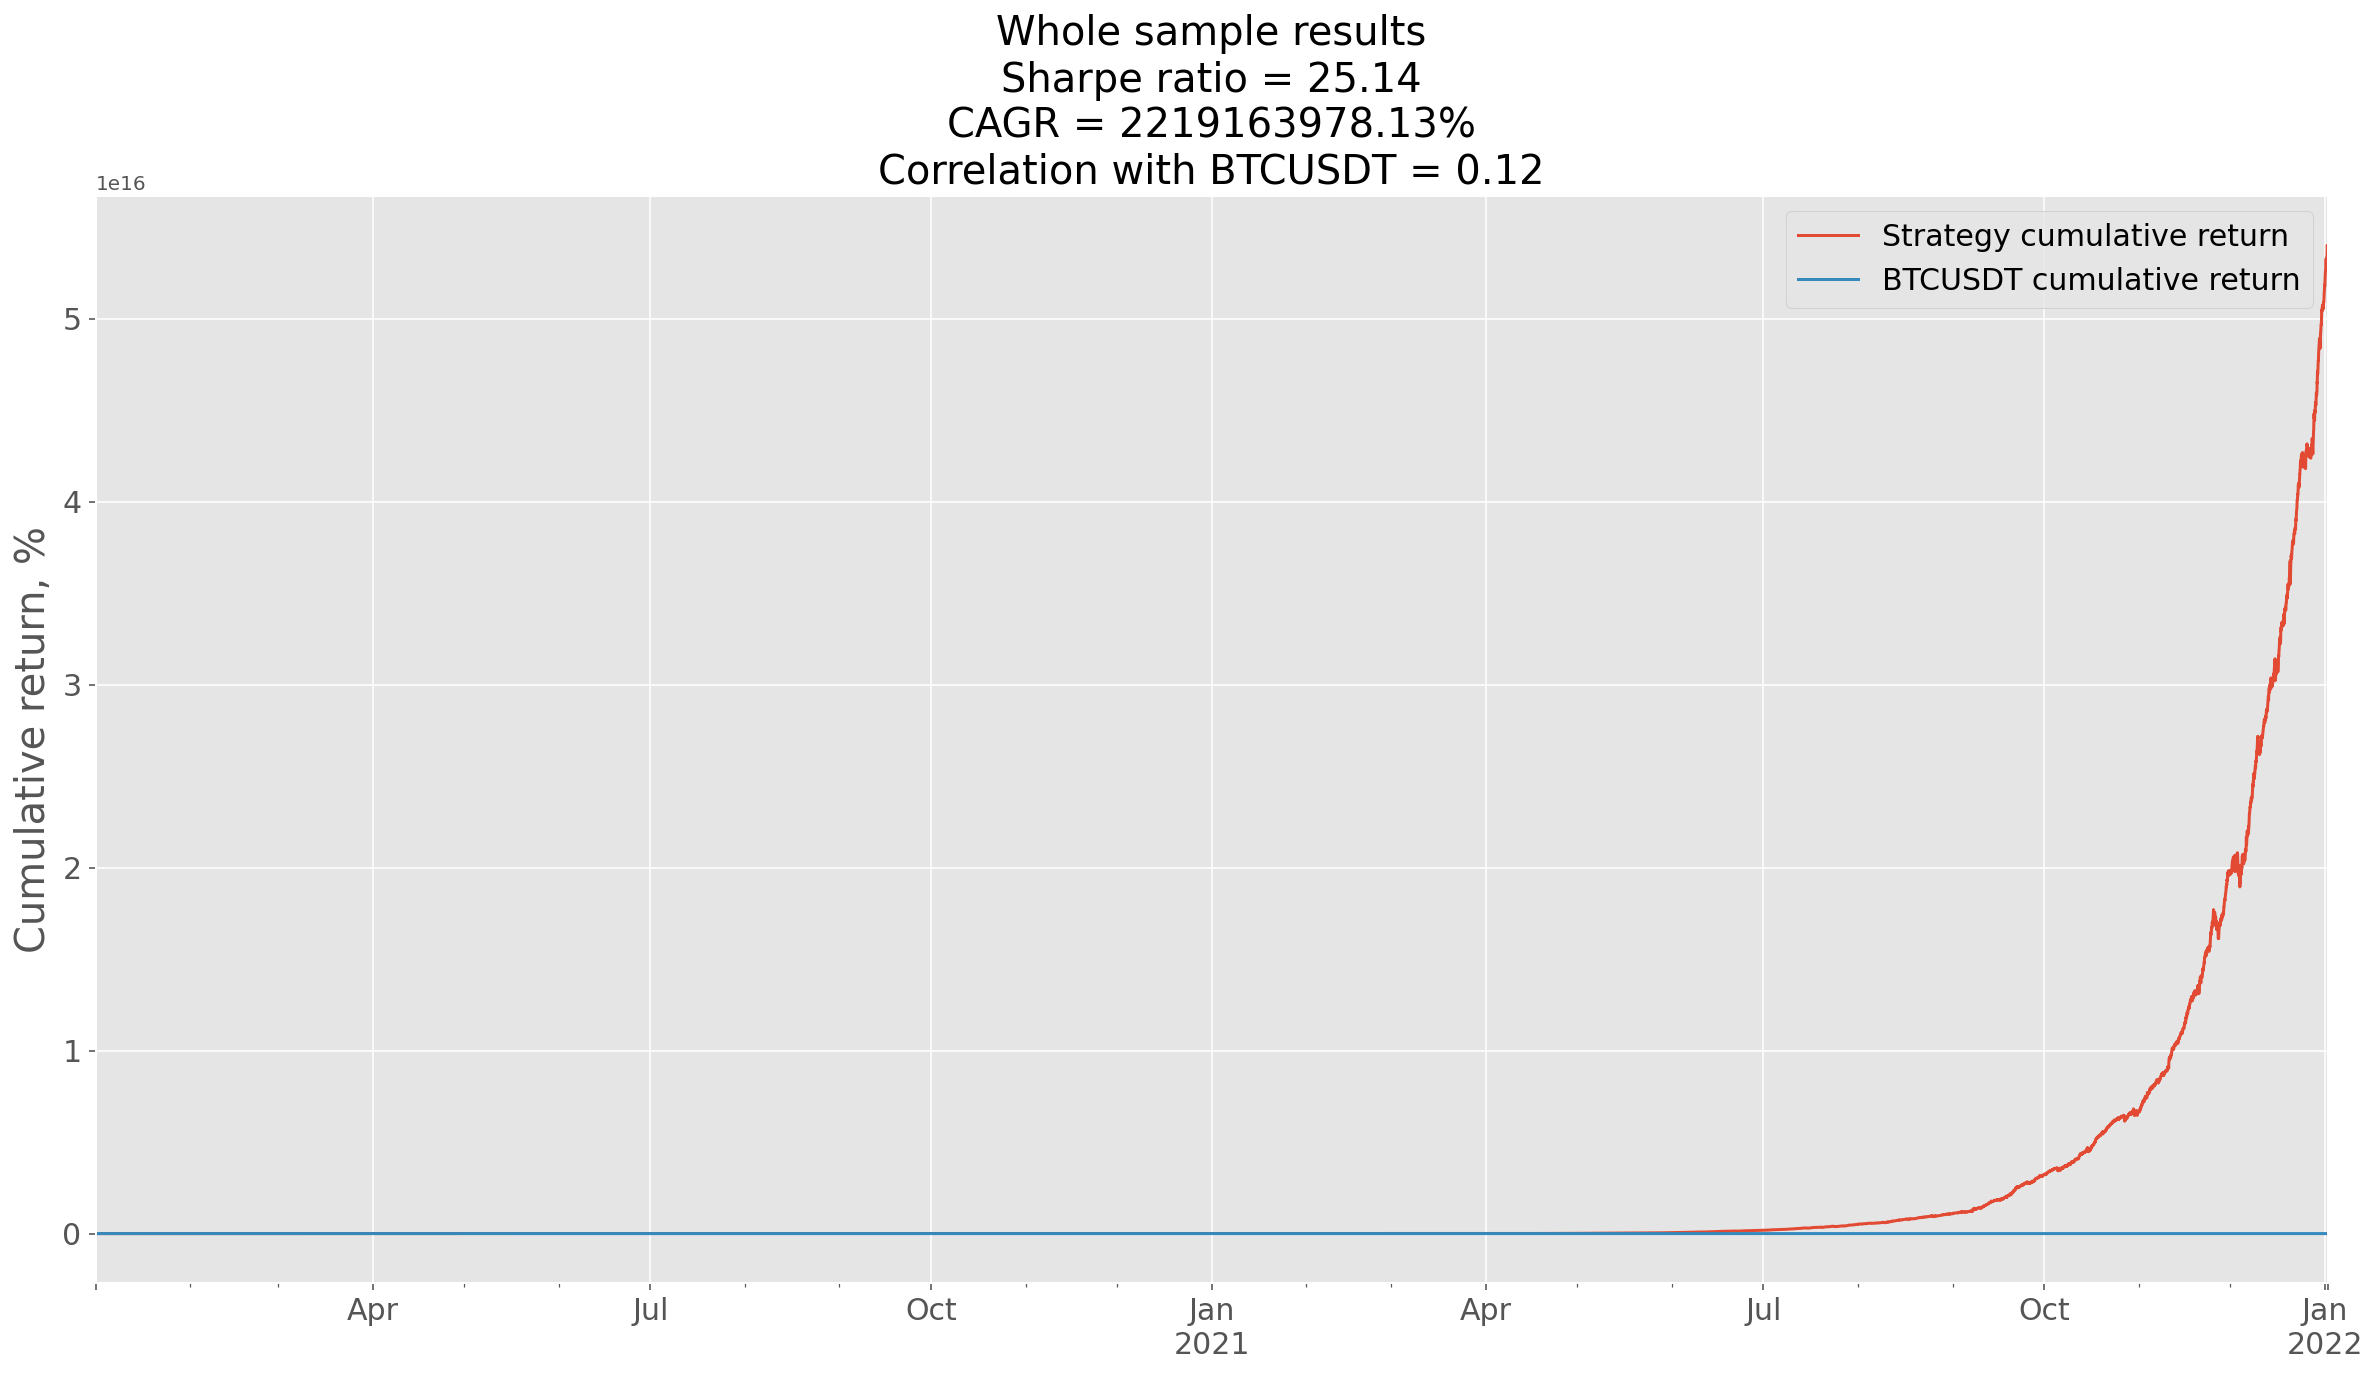

In [102]:
final_strategy = LongShortTradingStrategy(prices_data, benchmark_ticker='BTCUSDT')
final_strategy.set_strategy_params(up_q=0.07, down_q=0.07, max_t_in_pos=1)
final_strategy.run(log_trades=True)
plot_strategy_results(final_strategy, 'Whole sample results')

In [103]:
df = pd.DataFrame(final_strategy.trades_logs, columns=['timestamp', 'ticker', 'quantity', 'price'])
df = df.assign(trade_volume=df.quantity * df.price)
df = df.assign(cash_money_after_trade=np.cumsum(-df.trade_volume)+final_strategy.start_cap)
df = df.assign(abs_trade_volume_cash_money_fraction=np.abs(df.trade_volume)/(df.trade_volume+df.cash_money_after_trade))
df.head(10)

,timestamp,ticker,quantity,price,trade_volume,cash_money_after_trade,abs_trade_volume_cash_money_fraction
0,2020-01-01 01:00:00,CVCUSDT,9.290227e+06,0.017940,166666.666667,8.333333e+05,0.166667
1,2020-01-01 01:00:00,TUSDUSDT,1.661682e+05,1.003000,166666.666667,6.666667e+05,0.200000
2,2020-01-01 01:00:00,BUSDUSDT,1.661185e+05,1.003300,166666.666667,5.000000e+05,0.250000
3,2020-01-01 01:00:00,IOSTUSDT,-3.515433e+07,0.004741,-166666.666667,6.666667e+05,0.333333
4,2020-01-01 01:00:00,ATOMUSDT,-3.885004e+04,4.290000,-166666.666667,8.333333e+05,0.250000
5,2020-01-01 01:00:00,ETHUSDT,-1.275771e+03,130.640000,-166666.666667,1.000000e+06,0.200000
6,2020-01-01 02:00:00,CVCUSDT,-9.290227e+06,0.017870,-166016.350799,1.166016e+06,0.166016
7,2020-01-01 02:00:00,TUSDUSDT,-1.661682e+05,1.003000,-166666.666667,1.332683e+06,0.142937
8,2020-01-01 02:00:00,BUSDUSDT,-1.661185e+05,1.003300,-166666.666667,1.499350e+06,0.125061
9,2020-01-01 02:00:00,IOSTUSDT,3.515433e+07,0.004769,167650.987837,1.331699e+06,0.111816


In [104]:
portf = {ticker : 0.0 for ticker in prices_data.columns}

abs_trade_volume_cash_money_fraction_at_open = []

for i in df.index:
    if abs(portf[df.loc[i, 'ticker']]) < 1e-6:
        abs_trade_volume_cash_money_fraction_at_open.append((i, df.loc[i, 'abs_trade_volume_cash_money_fraction']))
    portf[df.loc[i, 'ticker']] += df.loc[i, 'quantity']

The final value of the strategy capital equals to the resotred value

In [105]:
# if current price is empty, we use previous to calculate portfolio value
prices = prices_data.fillna(method='pad').loc[prices_data.index[-1], portf.keys()]
portf_value = (prices * [item[-1] for item in portf.items()]).sum()
portf_value + df.cash_money_after_trade.values[-1], final_strategy.cap[-1]

(5.392539242161616e+20, 5.3925392421616144e+20)

Max value of proportion of the trade volume in cash money before trade is at the opening of the position does not exceed 1

In [106]:
max(abs_trade_volume_cash_money_fraction_at_open, key=itemgetter(-1))

(612527, 1.0000000000002154)

Prices from the logs match prices from the dataset

In [93]:
df = df.assign(price_check = 0.0)
tickers = df.ticker.unique()
for ticker in tickers:
    df.loc[df.ticker == ticker, 'price_check'] =\
    prices_data.loc[df[df.ticker == ticker].timestamp.values, ticker].values
    
df.head(10)

,timestamp,ticker,quantity,price,trade_volume,cash_money_after_trade,abs_trade_volume_cash_money_fraction,price_check
0,2020-01-01 01:00:00,CVCUSDT,9.290227e+06,0.017940,166666.666667,8.333333e+05,0.166667,0.017940
1,2020-01-01 01:00:00,TUSDUSDT,1.661682e+05,1.003000,166666.666667,6.666667e+05,0.200000,1.003000
2,2020-01-01 01:00:00,BUSDUSDT,1.661185e+05,1.003300,166666.666667,5.000000e+05,0.250000,1.003300
3,2020-01-01 01:00:00,IOSTUSDT,-3.515433e+07,0.004741,-166666.666667,6.666667e+05,0.333333,0.004741
4,2020-01-01 01:00:00,ATOMUSDT,-3.885004e+04,4.290000,-166666.666667,8.333333e+05,0.250000,4.290000
5,2020-01-01 01:00:00,ETHUSDT,-1.275771e+03,130.640000,-166666.666667,1.000000e+06,0.200000,130.640000
6,2020-01-01 02:00:00,CVCUSDT,-9.290227e+06,0.017870,-166016.350799,1.166016e+06,0.166016,0.017870
7,2020-01-01 02:00:00,TUSDUSDT,-1.661682e+05,1.003000,-166666.666667,1.332683e+06,0.142937,1.003000
8,2020-01-01 02:00:00,BUSDUSDT,-1.661185e+05,1.003300,-166666.666667,1.499350e+06,0.125061,1.003300
9,2020-01-01 02:00:00,IOSTUSDT,3.515433e+07,0.004769,167650.987837,1.331699e+06,0.111816,0.004769


In [95]:
(df.price == df.price_check).all()

True